In [2]:
from fastprogress import master_bar, progress_bar
import glob
import imageio
import IPython.display as display
import pandas as pd
import random
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")
from dataset import CigaretteLighterDataset
from models import Generator, Discriminator, weights_init
from losses import Losses

In [3]:
SEED = 999
G_LR = 2e-4
D_LR = 2e-4
BATCH_SIZE = 16
IMAGE_SIZE = 64
EPOCHS = 500

In [4]:
print("Random Seed: ", SEED)
random.seed(SEED)
torch.manual_seed(SEED)

Random Seed:  999


In [5]:
data_dir = '/workspace/src/data/cigarette_lighter/trim/'
file_path = glob.glob(data_dir+'*')

In [6]:
original_data = CigaretteLighterDataset(
    mode = 'generate',
    x = file_path,
    image_size = IMAGE_SIZE
)
original_loader = data.DataLoader(
    original_data,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 4,
    pin_memory = False,
    drop_last = True
)

In [7]:
generator = Generator(image_size=IMAGE_SIZE)
discriminator = Discriminator(image_size=IMAGE_SIZE)
generator.apply(weights_init)
discriminator.apply(weights_init)

criterion = Losses(loss_type='bce', batch_size=BATCH_SIZE)

fixed_noise = torch.randn(BATCH_SIZE, 100)

optimizerG = optim.Adam(generator.parameters(), lr=G_LR, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=D_LR, betas=(0.5, 0.999))

In [8]:
def generate_and_save_images(model, epoch, test_input):
    model.eval()
    predictions = model(test_input)
    predictions = predictions.detach().numpy()
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i].transpose(1, 2, 0) * 127.5 + 127.5).astype(np.uint8))
        plt.axis('off')
    plt.savefig('../generate_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train start

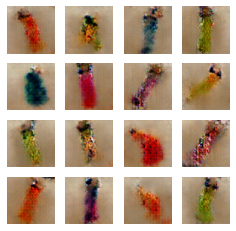

EPOCH500 eta: 0.095min | G_loss: 5.176, D_loss: 0.449


In [9]:
mb = master_bar(range(EPOCHS))
for epoch in mb:
    D_losses = []
    G_losses = []
    start = time.time()
    for it, images in enumerate(progress_bar(original_loader, parent=mb)):
        discriminator.zero_grad()
        images = images.float()
        outputs = discriminator(images).view(-1)
        lossD_real = criterion(outputs, 'discriminator_real')
        lossD_real.backward()

        noise = torch.randn(BATCH_SIZE, 100)
        fakes = generator(noise)
        outputs = discriminator(fakes.detach()).view(-1)
        lossD_fake = criterion(outputs, 'discriminator_fake')
        lossD_fake.backward()

        lossD = lossD_real + lossD_fake
        optimizerD.step()

        generator.zero_grad()
        outputs = discriminator(fakes).view(-1)
        lossG = criterion(outputs, 'generator')
        lossG.backward()
        optimizerG.step()

        D_losses.append(lossD.item())
        G_losses.append(lossG.item())

        mb.child.comment = (
            "G_loss: {:.3f}, D_loss: {:.3f}".format(
                np.mean(G_losses),
                np.mean(D_losses)
            )
        )

    display.clear_output(wait=True)
    if (epoch+1) % 5 == 0 or epoch == 0:
        generate_and_save_images(
            generator,
            epoch + 1,
            fixed_noise
        )
    print(
        "EPOCH{:s} eta: {:.3f}min | G_loss: {:.3f}, D_loss: {:.3f}".format(
            str(epoch+1),
            (time.time() - start) / 60.0,
            np.mean(G_losses),
            np.mean(D_losses)
        )
    )
torch.save(generator, '../output_models/generator{:d}'.format(
    epoch+1
))

## Output learning process

In [11]:
anim_file = 'learning_process_animation.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('../generate_images/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)